In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Create class object for a single linear ucb disjoint arm
class linucb_disjoint_arm():
    
    def __init__(self, arm_index, d, alpha):
        
        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
        
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)
        
        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        self.theta = np.dot(A_inv, self.b)
        
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector
        p = np.dot(self.theta.T,x) +  self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv,x)))
        
        return p
    
    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Update A which is (d * d) matrix.
        self.A += np.dot(x, x.T)
        
        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += reward * x 

In [3]:
class linucb_policy():
    
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -1
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            
            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_ucb == highest_ucb:
                
                candidate_arms.append(arm_index)
        
        # Choose based on candidate_arms randomly (tie breaker)
        chosen_arm = np.random.choice(candidate_arms)
        
        return chosen_arm

    def select_k_arms(self, x_array, k):
        arm_ucbs = sorted(((arm_index, self.linucb_arms[arm_index].calc_UCB(x_array)) for arm_index in range(self.K_arms)), key=lambda x: x[1], reverse=True)
        return [x for x, y in arm_ucbs[:k]]

In [4]:
def ctr_simulator(K_arms, d, alpha, data_path):
    # Initiate policy
    linucb_policy_object = linucb_policy(K_arms = K_arms, d = d, alpha = alpha)
    
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    # Open data
    with open(data_path, "r") as f:
        flag = True
        for line_data in tqdm(f):
            if flag:
                flag = False
                continue
            # 1st column: Logged data arm. 
            # Integer data type
            data_arm = int(line_data.split(',')[0])

            # 2nd column: Logged data reward for logged chosen arm
            # Float data type
            data_reward = float(line_data.split(',')[1])

            # 3rd columns onwards: 100 covariates. Keep in array of dimensions (100,) with float data type
            covariate_string_list = line_data.split(',')[2:]
            data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])

            # Find policy's chosen arm based on input covariates at current time step
            # arm_index = linucb_policy_object.select_arm(data_x_array)
            # Select top 3 arms
            arm_indexes = linucb_policy_object.select_k_arms(data_x_array, k=3)

            # If data_reward == 1 (user picked that arm)
            # Check if data_arm in arm_indexes
            # No = 0, yes = 1
            if data_reward == 1:
                arm_index = data_arm
                reward = int(data_arm in arm_indexes)
                # Use reward information for the chosen arm to update
                linucb_policy_object.linucb_arms[arm_index].reward_update(reward, data_x_array)

                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)
                    
    return (aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object)

0it [00:00, ?it/s]

10001it [07:29, 22.26it/s]


Text(0.5, 1.0, 'alpha = 1.5')

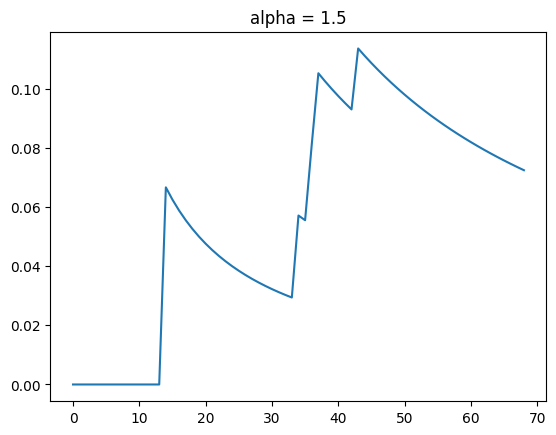

In [6]:
alpha_input = 1.5
data_path = "test_bts_men.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 34, d = 61, alpha = alpha_input, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))

10001it [08:57, 18.61it/s]


Text(0.5, 1.0, 'alpha = 1.5')

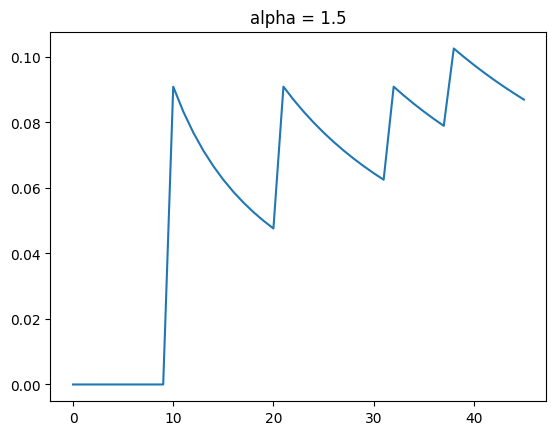

In [13]:
alpha_input = 1.5
data_path = "test_random_men.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 34, d = 60, alpha = alpha_input, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))

10001it [40:00,  4.17it/s]


Text(0.5, 1.0, 'alpha = 1.5')

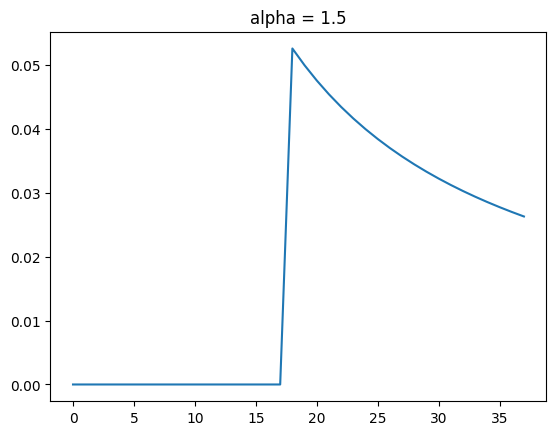

In [14]:
alpha_input = 1.5
data_path = "test_random_all.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 80, d = 105, alpha = alpha_input, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))

10001it [06:24, 26.02it/s]


Text(0.5, 1.0, 'alpha = 1.0')

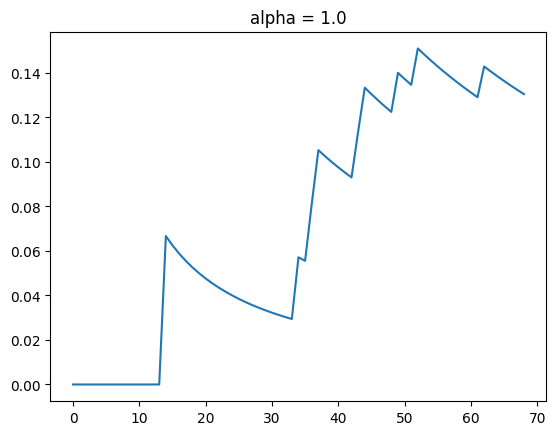

In [18]:
alpha_input = 1.0
data_path = "test_bts_men.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 34, d = 61, alpha = alpha_input, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))

10001it [07:38, 21.83it/s]


Text(0.5, 1.0, 'alpha = 1.0')

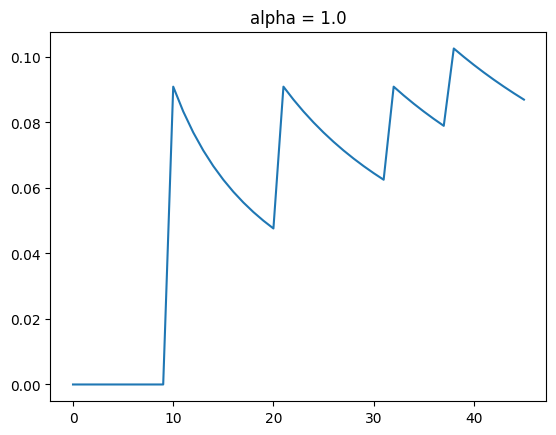

In [19]:
alpha_input = 1.0
data_path = "test_random_men.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 34, d = 60, alpha = alpha_input, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))

10001it [40:17,  4.14it/s]


Text(0.5, 1.0, 'alpha = 1.0')

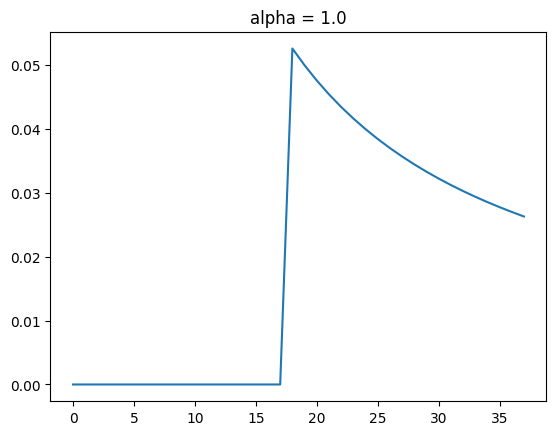

In [20]:
alpha_input = 1.0
data_path = "test_random_all.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 80, d = 105, alpha = alpha_input, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))

10001it [38:18,  4.35it/s]


Text(0.5, 1.0, 'alpha = 1.0')

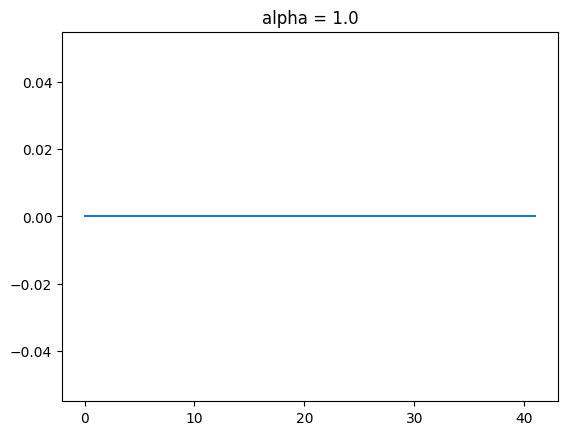

In [21]:
alpha_input = 1.0
data_path = "test_bts_all.csv"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 80, d = 107, alpha = alpha_input, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))